February: Images for Ocean Sciences poster - salinity anomaly pcolormesh slices. 

In [29]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

import warnings
warnings.filterwarnings("ignore")

In [30]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        (vmin,), _ = self.process_value(self.vmin)
        (vmax,), _ = self.process_value(self.vmax)
        resdat = np.asarray(result.data)
        result = np.ma.array(resdat, mask=result.mask, copy=False)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        res = np.interp(result, x, y)
        result = np.ma.array(res, mask=result.mask, copy=False)
        if is_scalar:
            result = result[0]
        return result

In [31]:
def get_vars(dirname, dep_ind):
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    y,x = slice(1,-1,None), slice(1,-1,None)
    time_ind = 24*13
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    filesU = general_functions.get_files(dirname, fname, 'grid_U')
            
    with scDataset(filesT) as dsT, scDataset(filesU) as dsU:
        deptht = dsT.variables['deptht'][:]
        vosaline0 = dsT.variables['vosaline'][:time_ind, dep_ind, y, x]
        sozotaux = dsU.variables['sozotaux'][:time_ind, 0, 0] 
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0, dep_ind, y, x]
        
    tmask = np.tile(tmask0, (len(sozotaux), 1, 1, 1))  
    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    
    return vosaline, sozotaux, deptht, tmask

In [32]:
def get_1day_avg(vel, day_start, day_end):
    day = slice(day_start*24, day_end*24, None)
    vel_day = np.mean(vel[day, ...], axis=0)
    return vel_day

In [33]:
def get_daily_vosaline(vosaline, tmask):
    
    # get daily salinity averages from hourly results
    vosaline_daily0 = np.full((vosaline.shape[-3]/24, vosaline.shape[-2], vosaline.shape[-1]), np.nan)
    for i in range(vosaline_daily0.shape[0]):
        day_start, day_end = i, i+1
        vosaline_daily0[i, :, :] = get_1day_avg(vosaline, day_start, day_end)

    tmask_new = np.tile(tmask[0, :, :, :], (vosaline_daily0.shape[0], 1, 1))
    vosaline_daily = np.ma.array(vosaline_daily0, mask=1 - tmask_new)

    print(type(vosaline_daily0), vosaline_daily0.shape, tmask_new.shape, vosaline_daily.shape, type(vosaline_daily))
    
    return vosaline_daily, tmask_new

In [34]:
def plot_saltanomaly_day(saltanomaly, deptht, dep_ind, n, cbarf, cpad, flag, kind):
    plot_array = saltanomaly[n, :, :]
    vmin, vmax = -2, 2
    cmap, norm = cmo.cm.curl, MidpointNormalize(midpoint=0)
    cmap.set_bad('silver')

    xs, ys = np.arange(plot_array.shape[-1])*2/3, np.arange(plot_array.shape[-2])*2/3
    
    fig, ax = plt.subplots(1, 1, figsize = (20, 15))
    p = ax.pcolormesh(xs, ys, plot_array, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
    cbar = fig.colorbar(p, ax=ax, fraction=cbarf, orientation='horizontal', pad=cpad)
    cbar.set_label('salt anomaly [g/kg]', fontsize=35, rotation=0, labelpad=3.0)
    tick_locator = ticker.MaxNLocator(nbins=4)
    cbar.locator = tick_locator
    cbar.update_ticks()
    cbar.ax.tick_params(labelsize=20)
    ax.tick_params(axis='both', which='both', labelsize=20)
    ax.set_aspect(aspect='equal')
    ax.set_xlim([0, xs[-1]])
    ax.set_ylim([0, ys[-1]])
    if flag == 'p' or flag == 'c':
        ax.set_title('Day ' + str(n+1) + ' ('+ str(int(deptht[dep_ind])) +' m)', fontsize=50)
        ax.set_ylabel('Cross-shore direction [km]', fontsize=35)
        ax.set_xlabel('Alongshore direction [km]', fontsize=35)
    levels = [-2, -1.5, -1, -0.5, -0.2, 0.2, 0.5, 1, 1.5, 2]#[int(x) for x in deptht]#
    cs = ax.contour(xs, ys, plot_array, levels = levels, colors='k', alpha=0.7, lw=2)
    ax.clabel(cs, inline=1, fontsize=16, fmt='%1.1f')
    fig.tight_layout()
    fig.savefig('../../OSM_images/d'+str(int(deptht[dep_ind]))+'_saltanom_'+kind+'_'+flag+str(n+1)+'.png')
    return fig

# Depth index

In [35]:
dep_ind = 11

# Reference Salinity

In [36]:
vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]
vosaline_ref_value = vosaline_ref[0, dep_ind, 0, 0]
vosaline_ref_value

32.552853

# Ideal

In [37]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_half_flt/'
vosaline, sozotaux, deptht, tmask = get_vars(dirname, dep_ind)

In [38]:
vosaline_daily, tmask_new = get_daily_vosaline(vosaline, tmask)

saltanomaly = vosaline_daily - vosaline_ref_value

<class 'numpy.ndarray'> (13, 272, 242) (13, 272, 242) (13, 272, 242) <class 'numpy.ma.core.MaskedArray'>


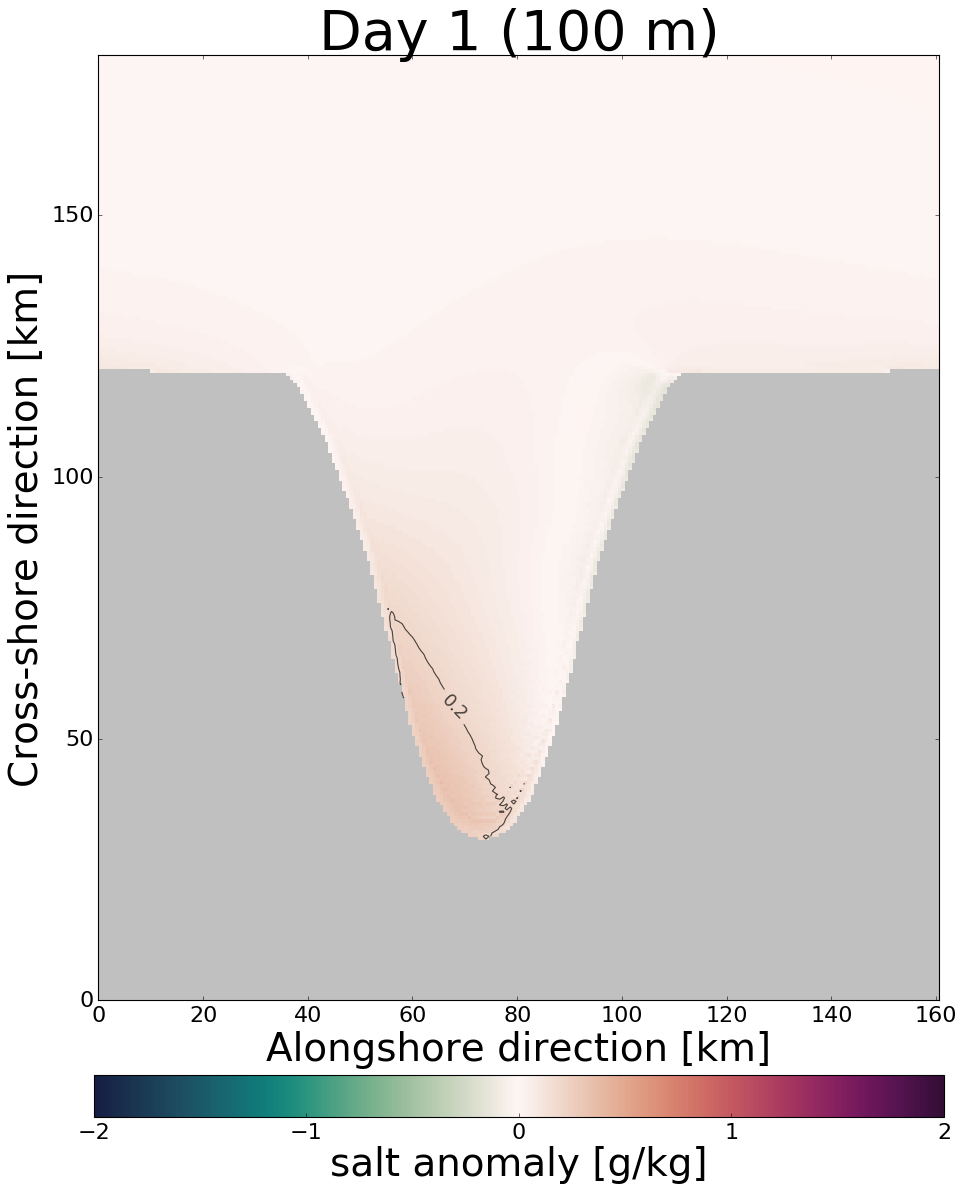

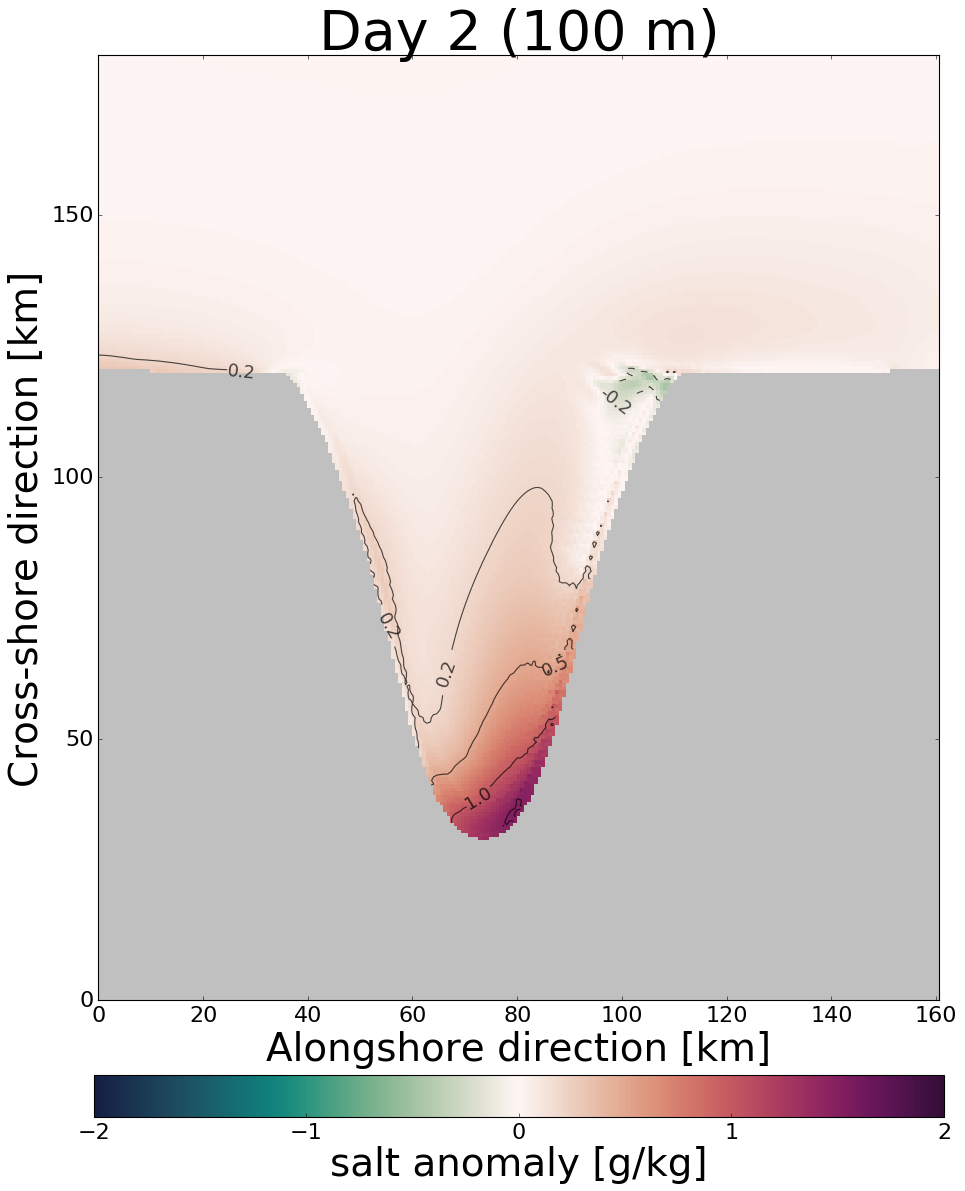

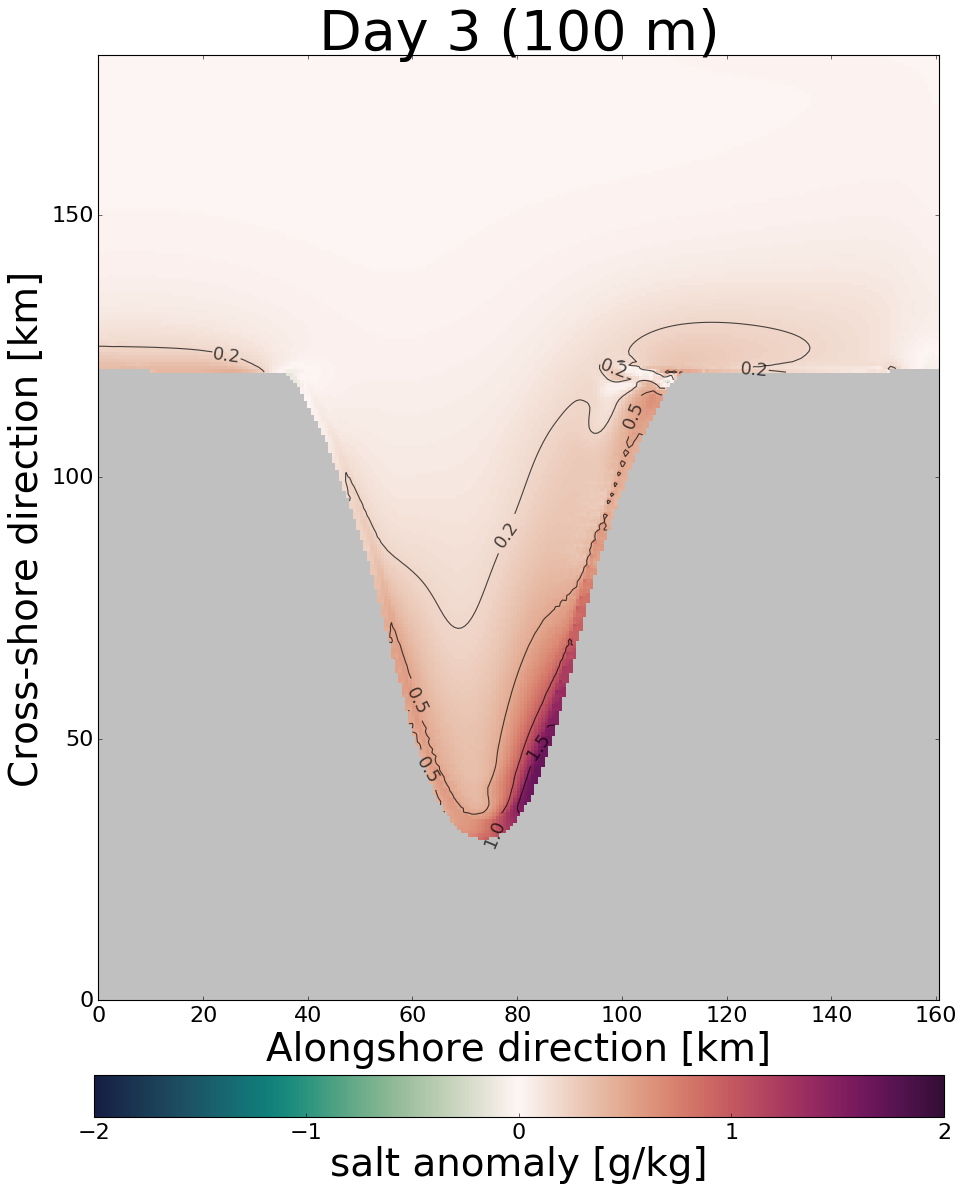

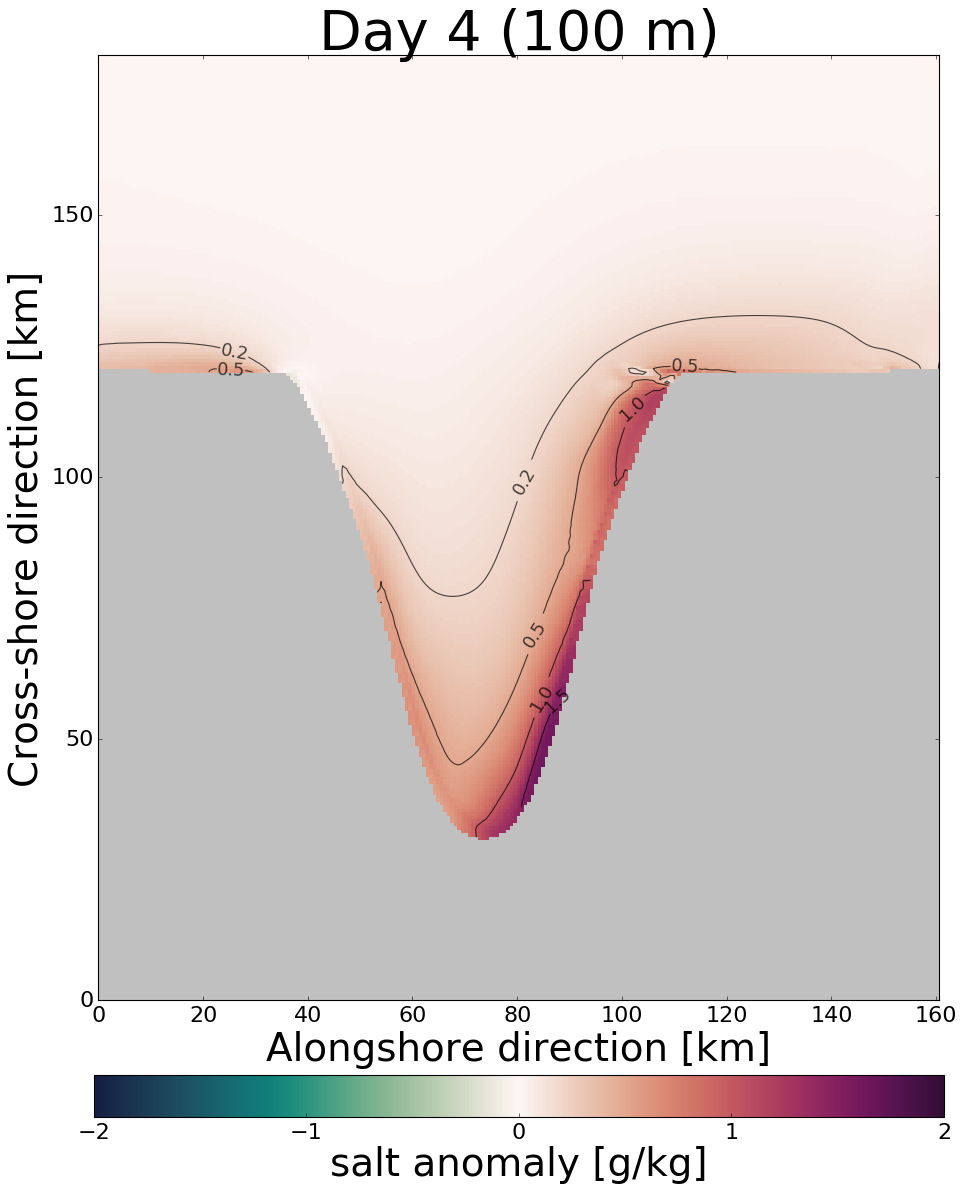

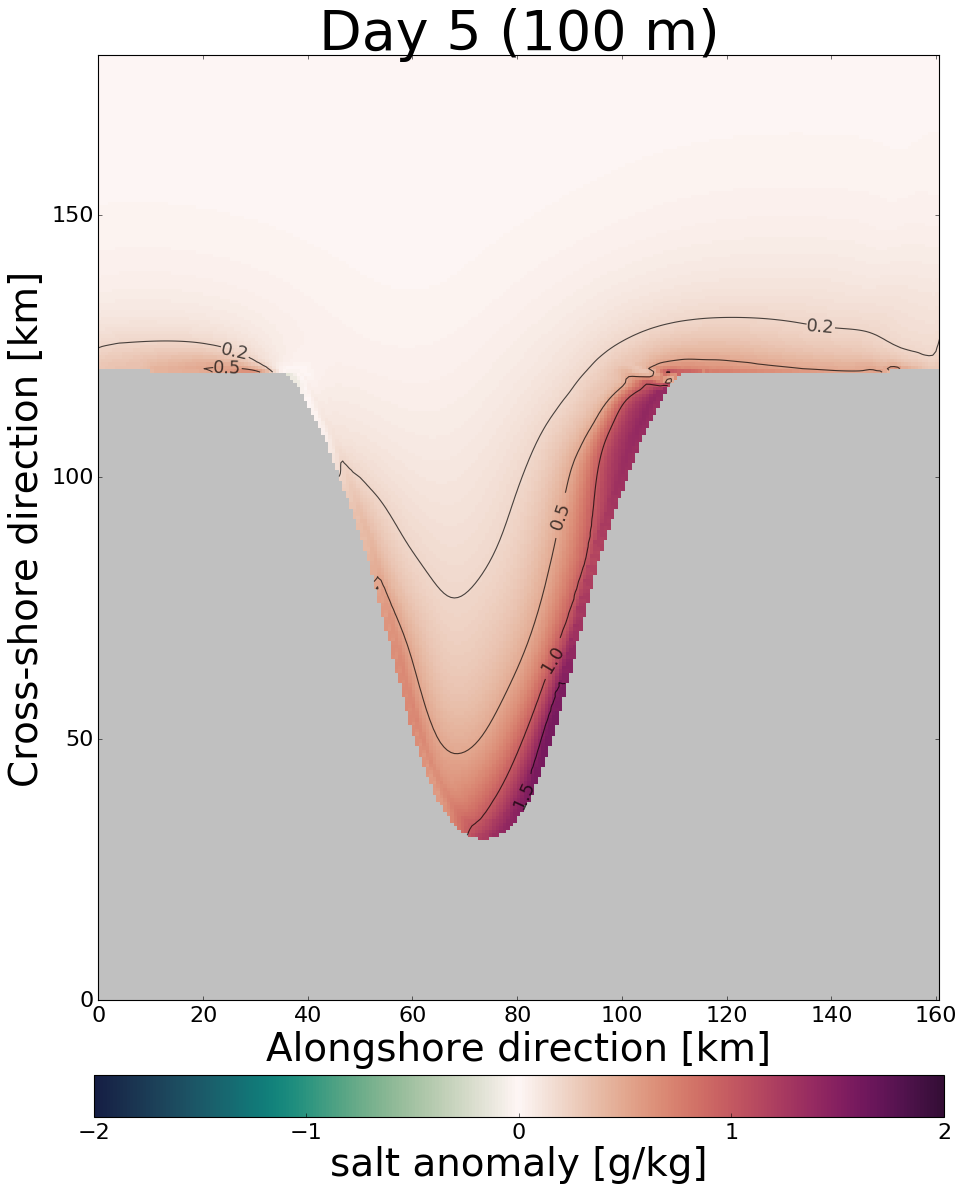

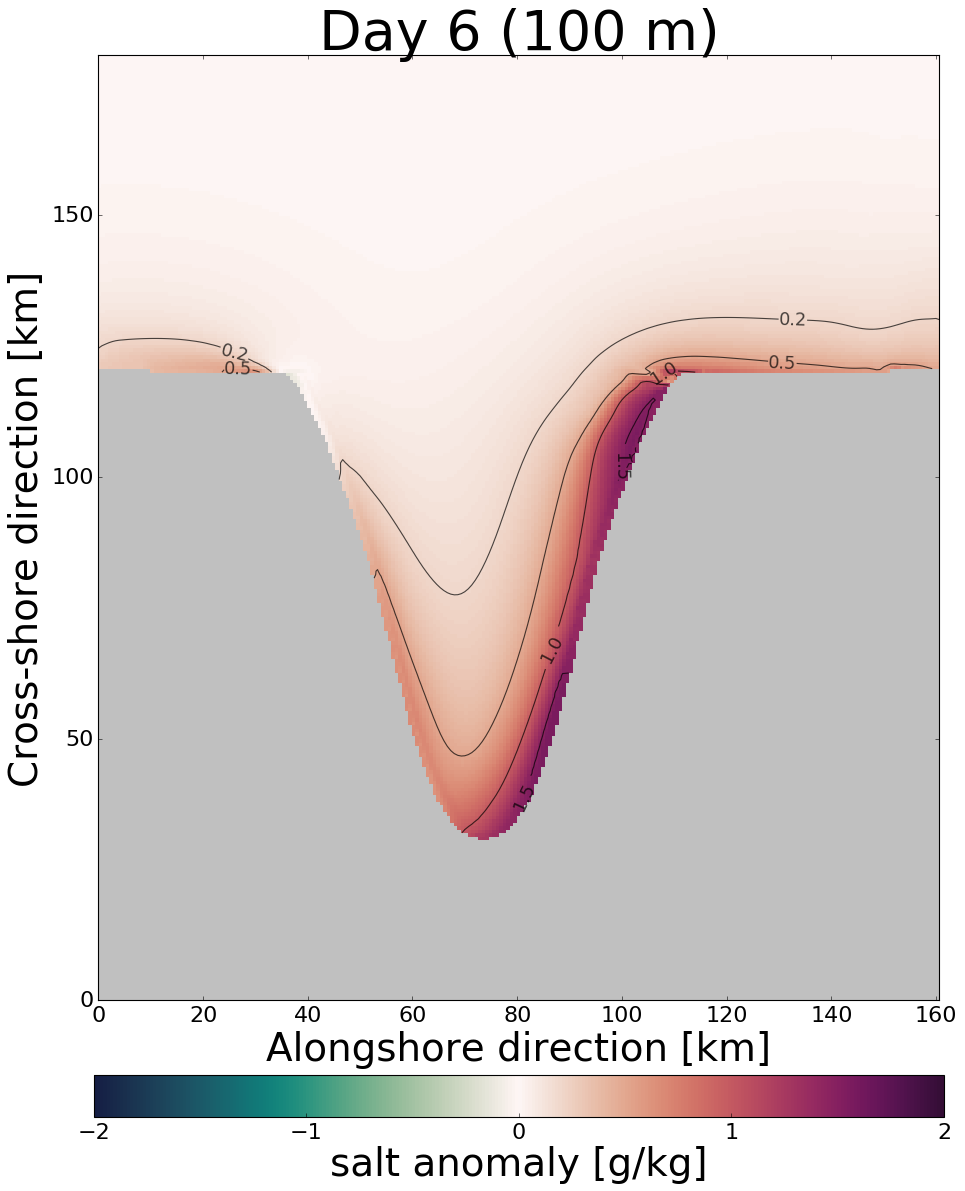

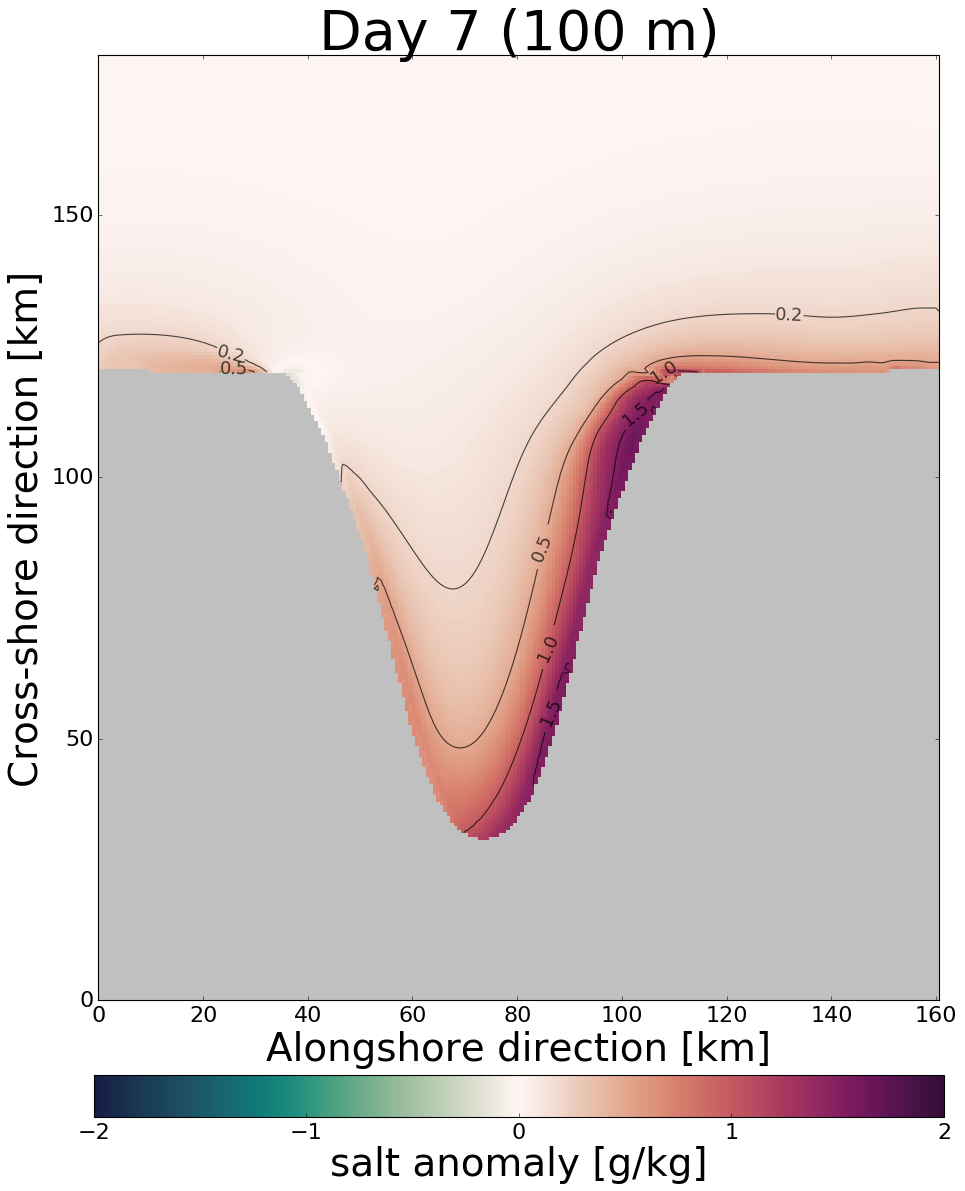

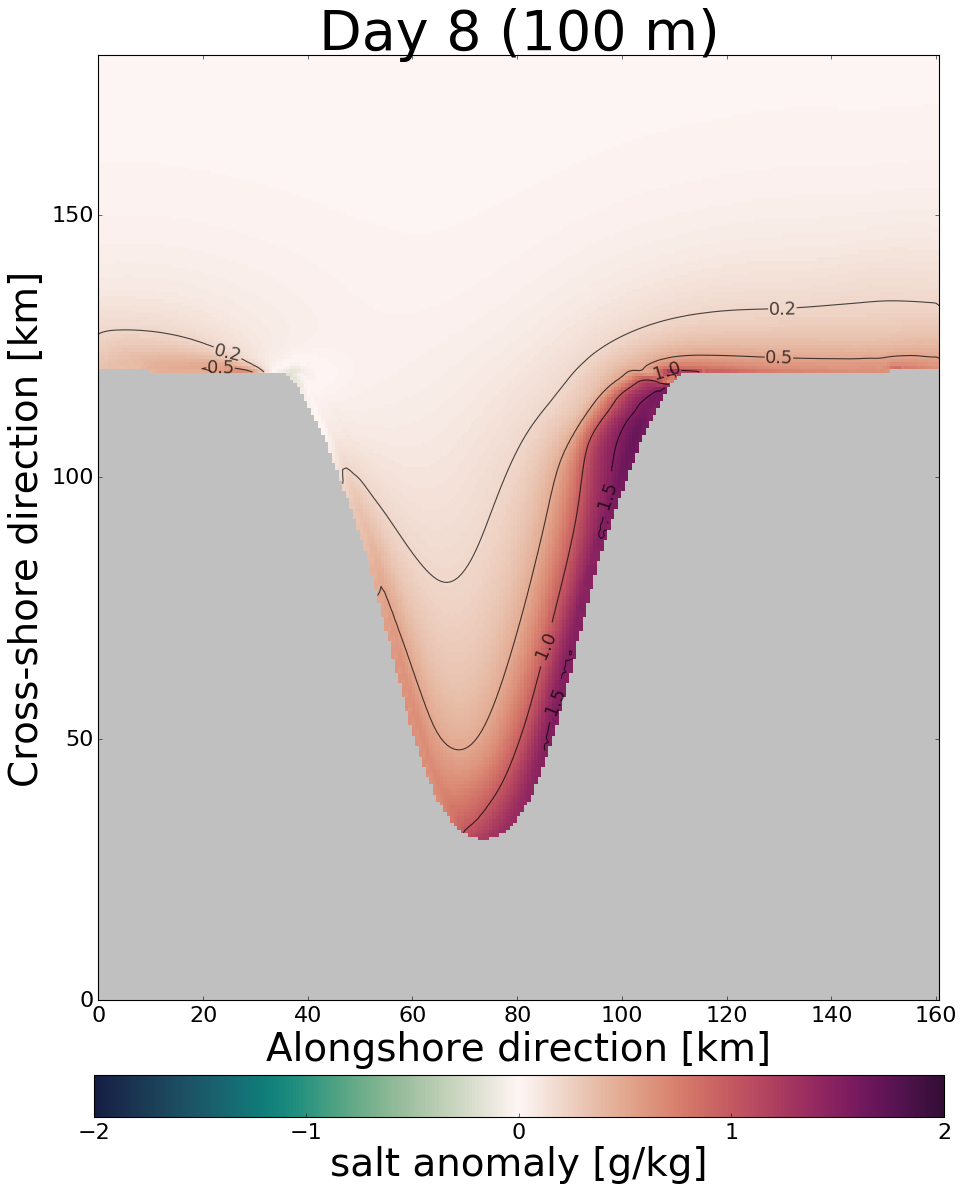

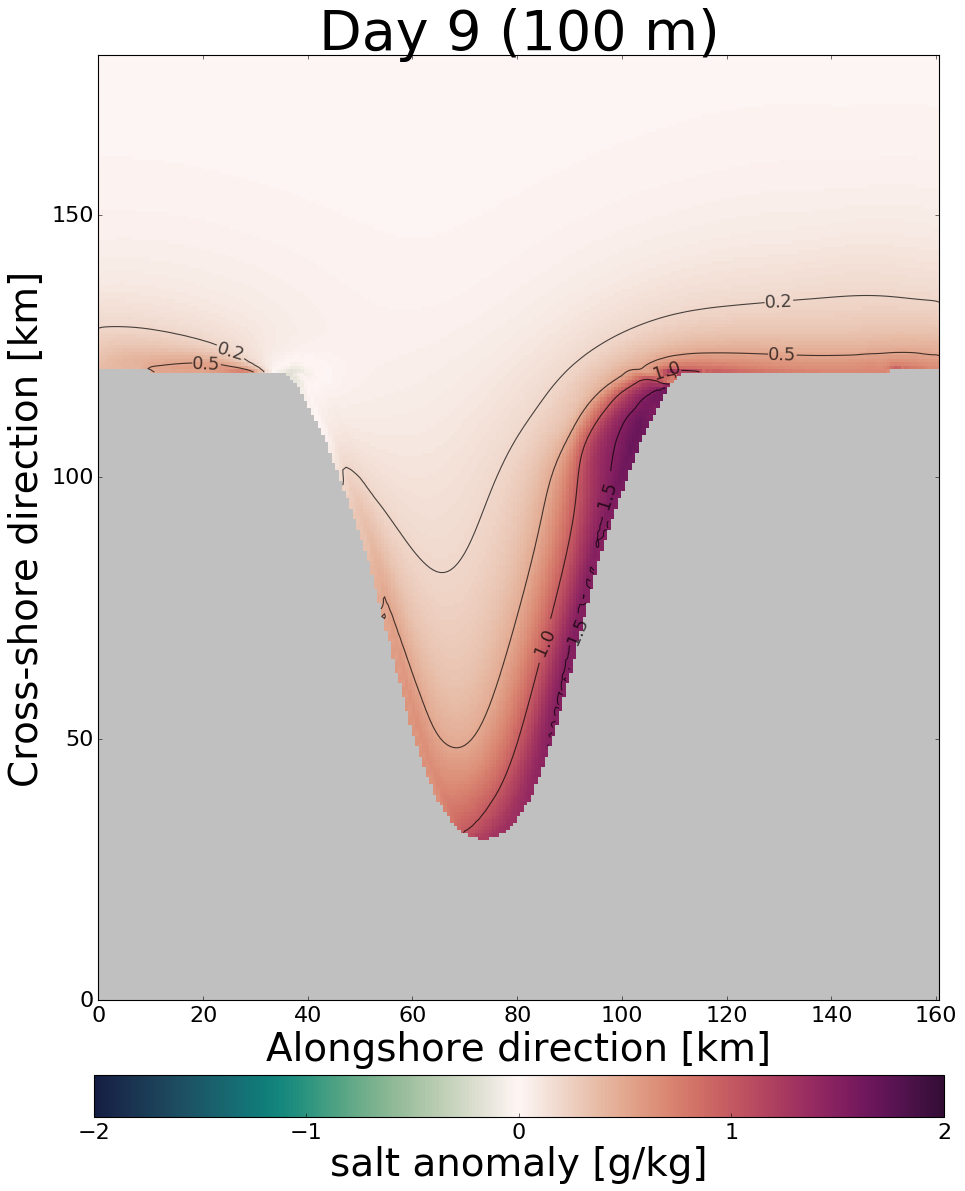

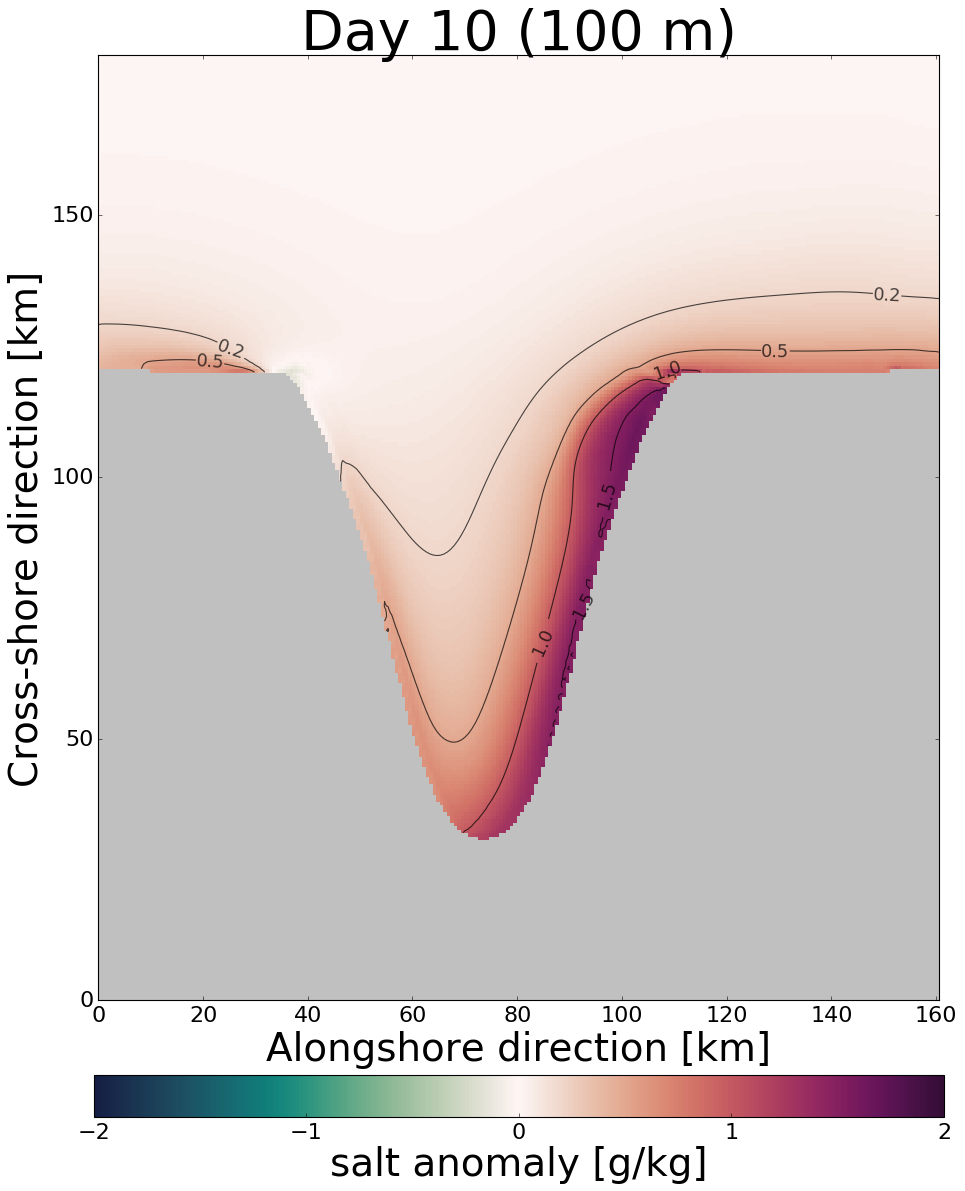

In [39]:
cbarf, cpad = 0.04, 0.07

for n in np.arange(10):
    fig = plot_saltanomaly_day(saltanomaly, deptht, dep_ind, n, cbarf, cpad, 'c', 'ideal')

# Real

In [40]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/real_half/'
vosaline, sozotaux, deptht, tmask = get_vars(dirname, dep_ind)

In [41]:
vosaline_daily, tmask_new = get_daily_vosaline(vosaline, tmask)

saltanomaly = vosaline_daily - vosaline_ref_value

<class 'numpy.ndarray'> (13, 272, 182) (13, 272, 182) (13, 272, 182) <class 'numpy.ma.core.MaskedArray'>


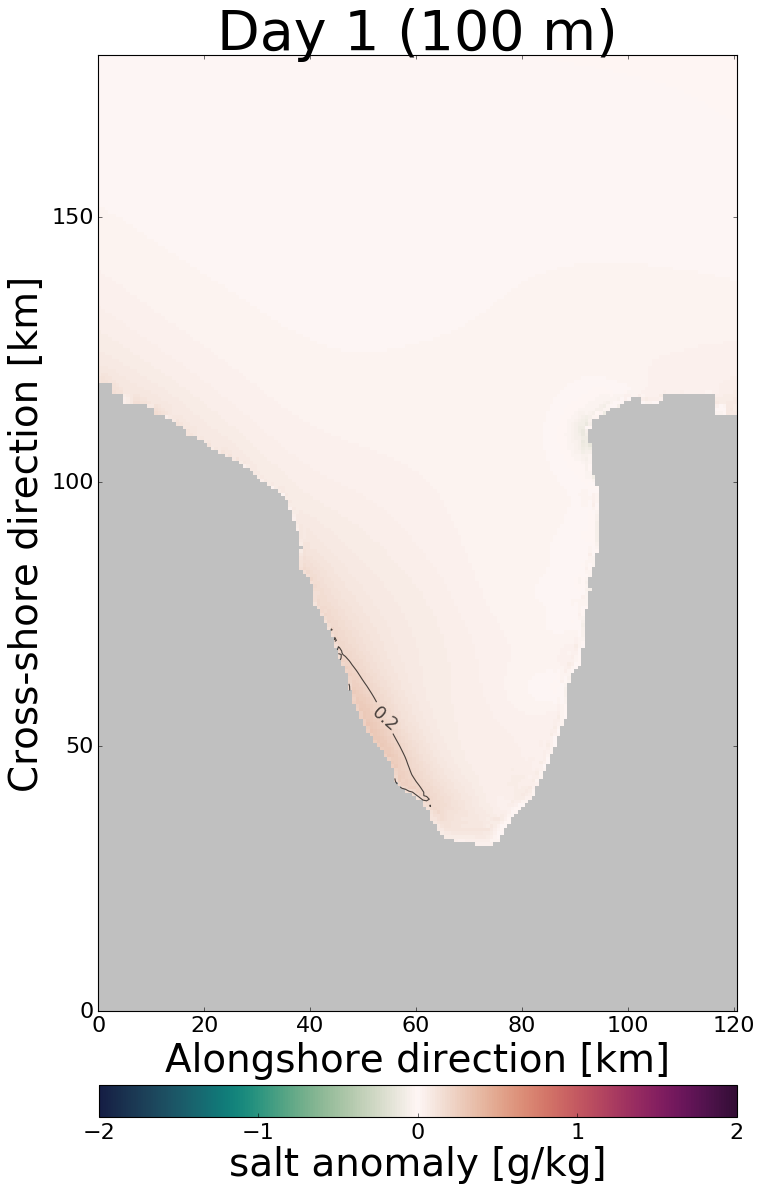

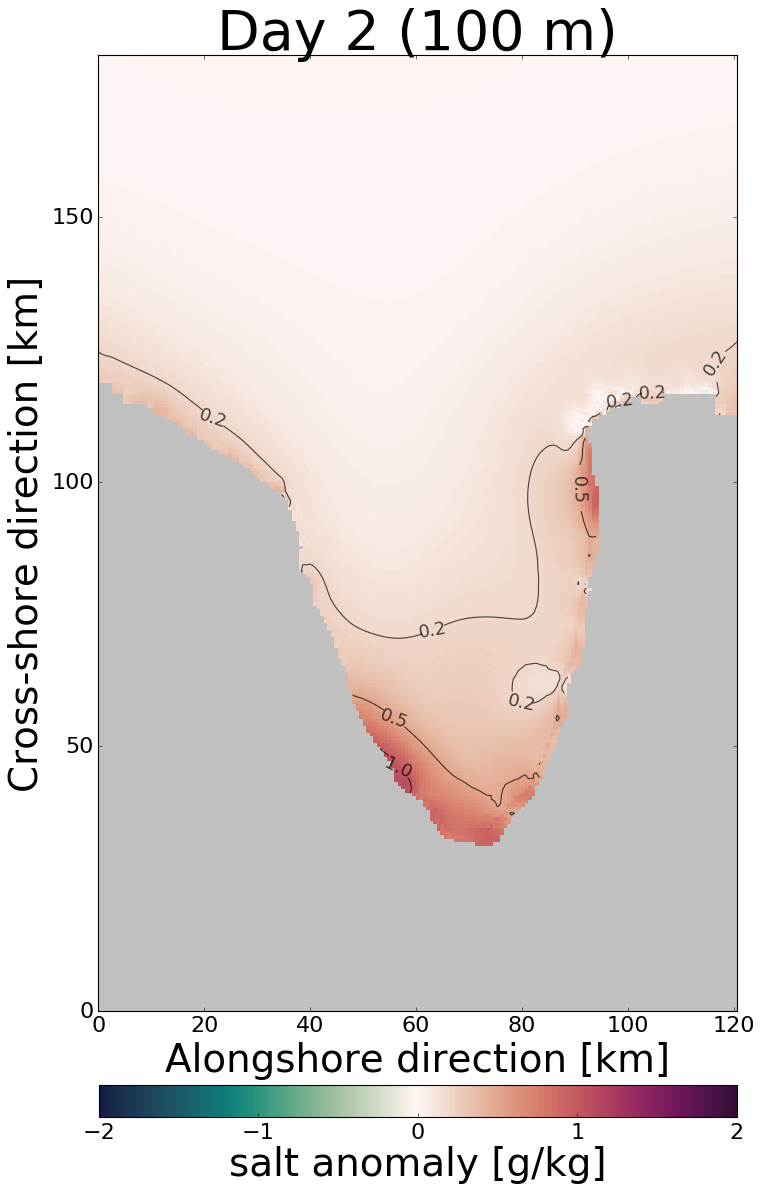

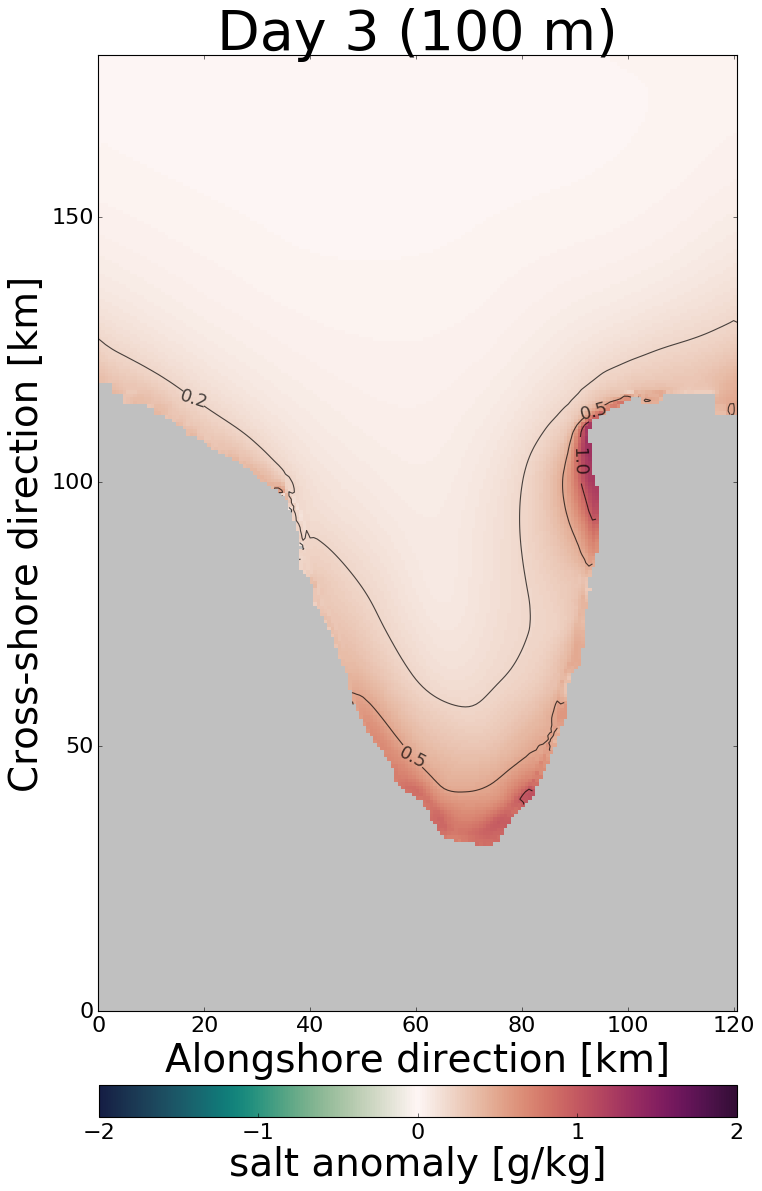

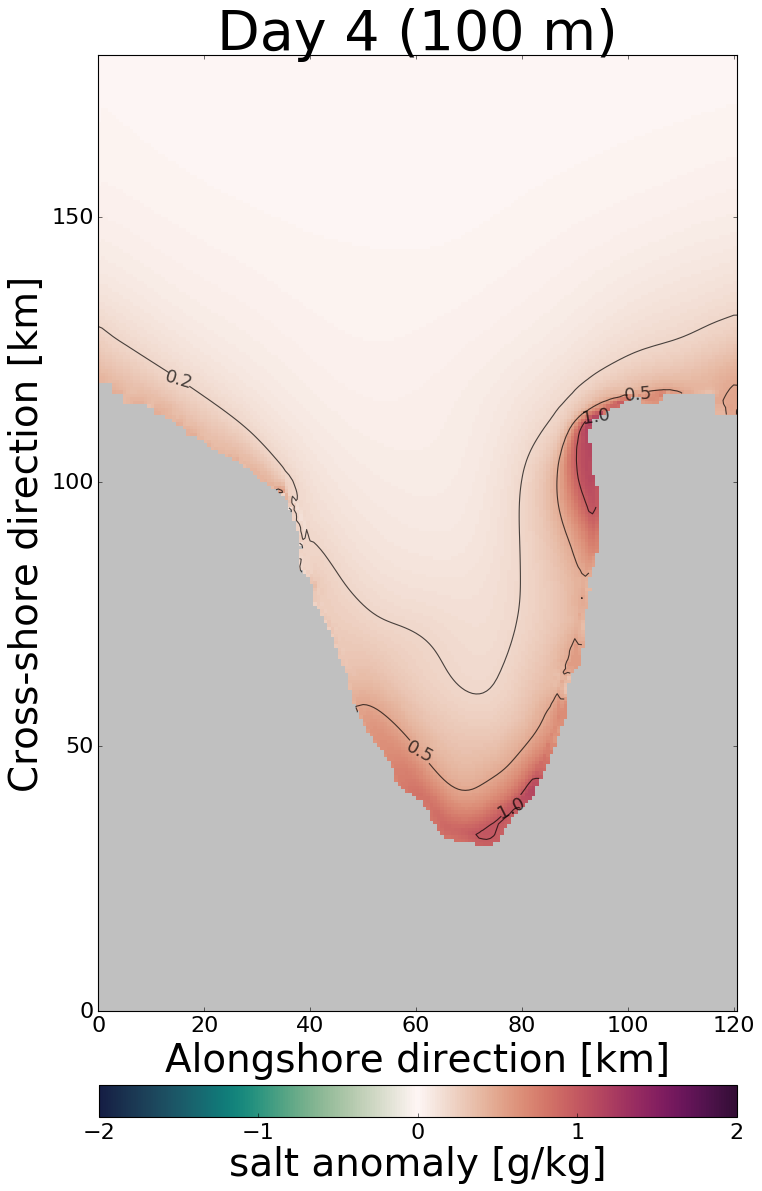

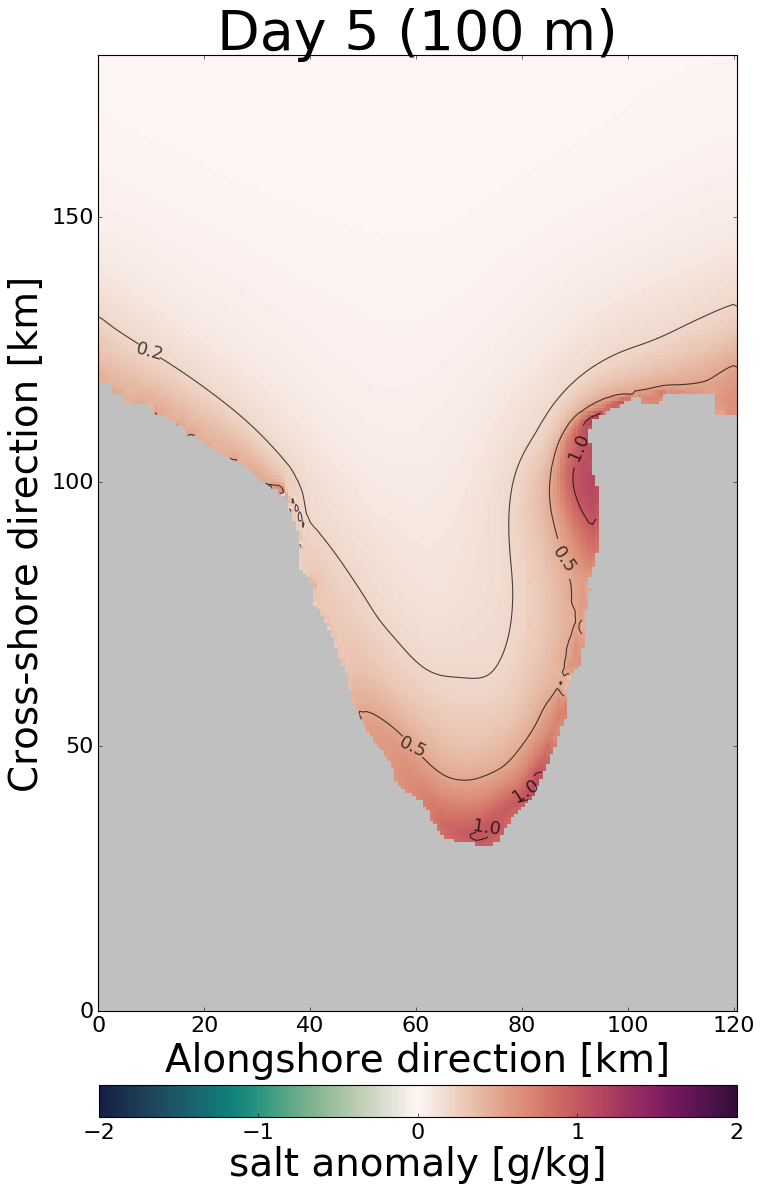

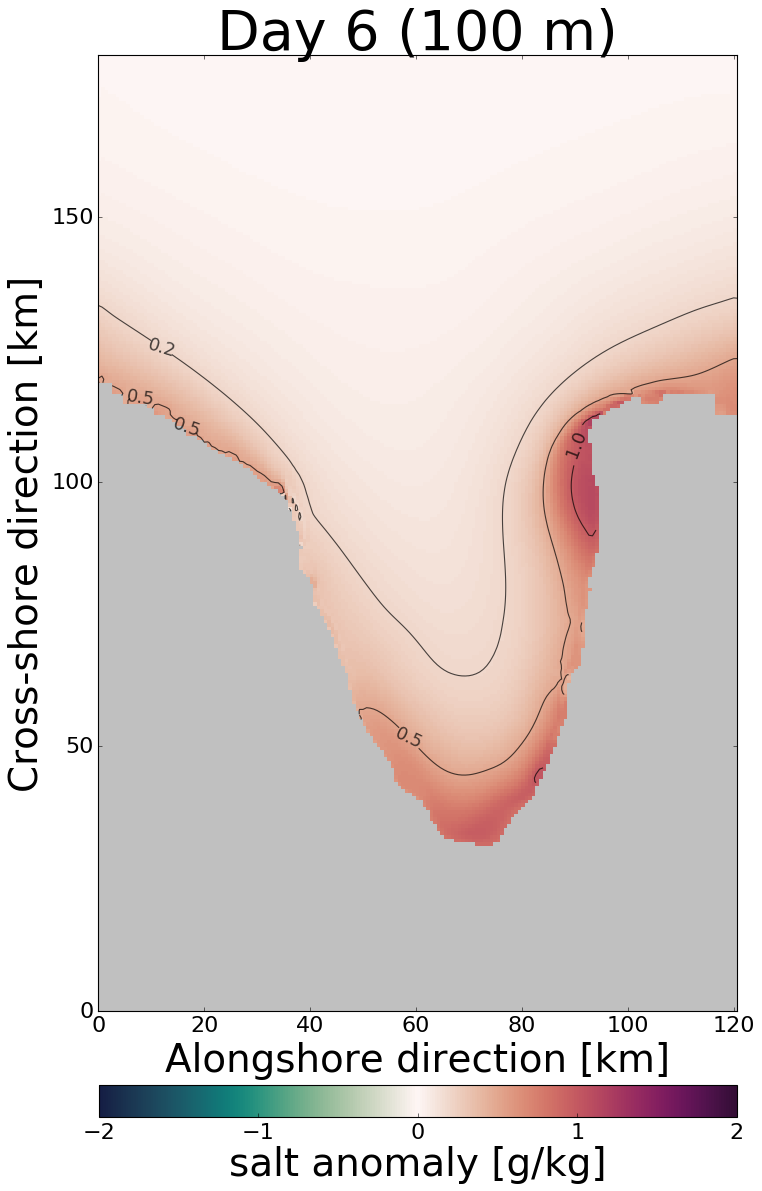

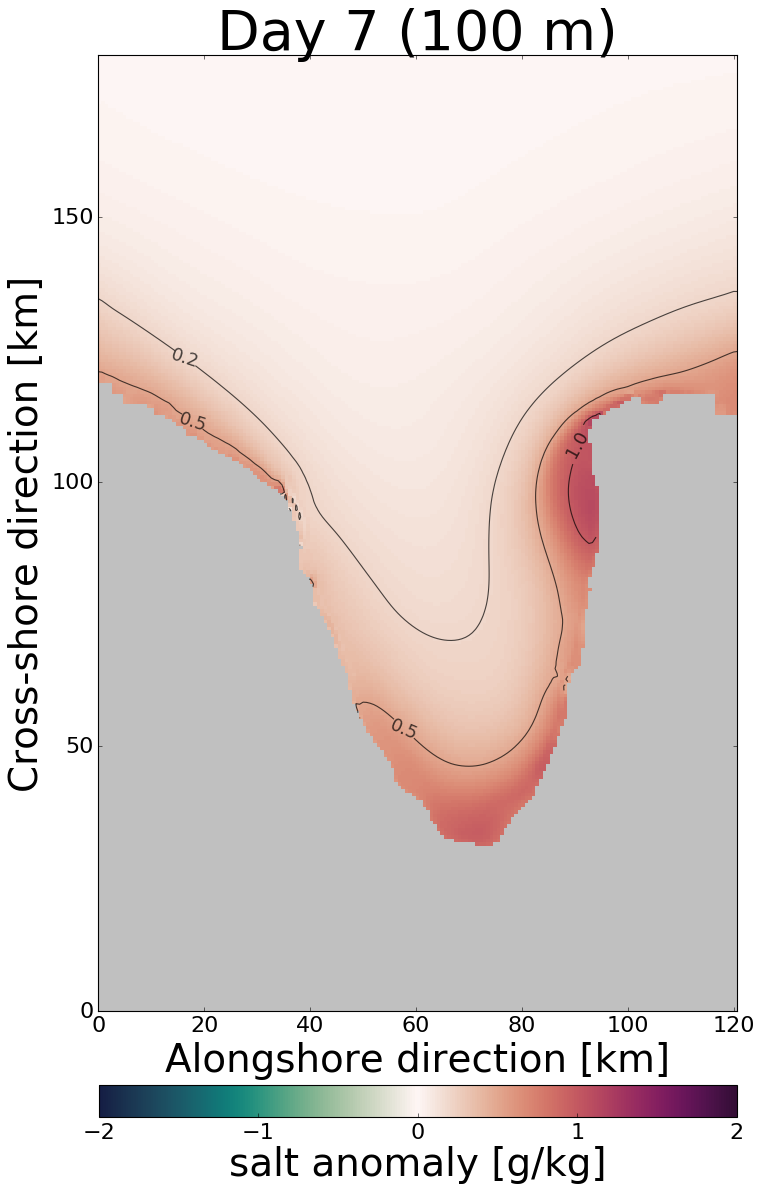

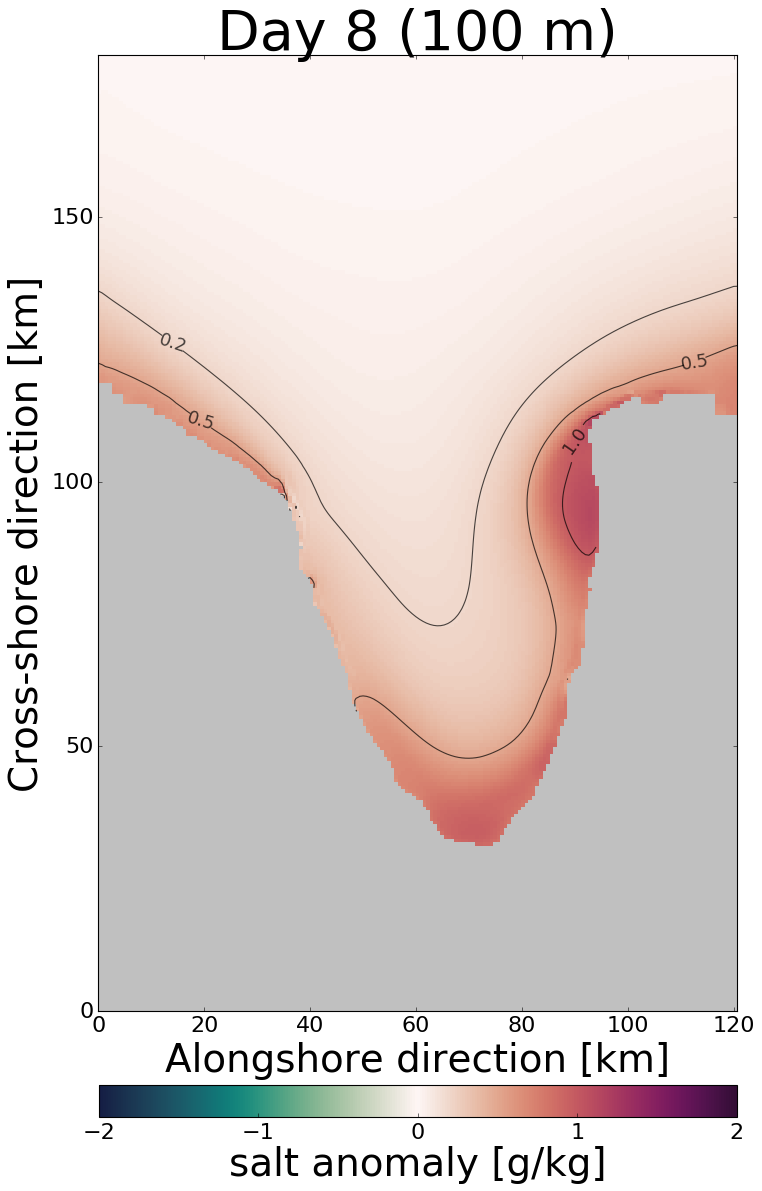

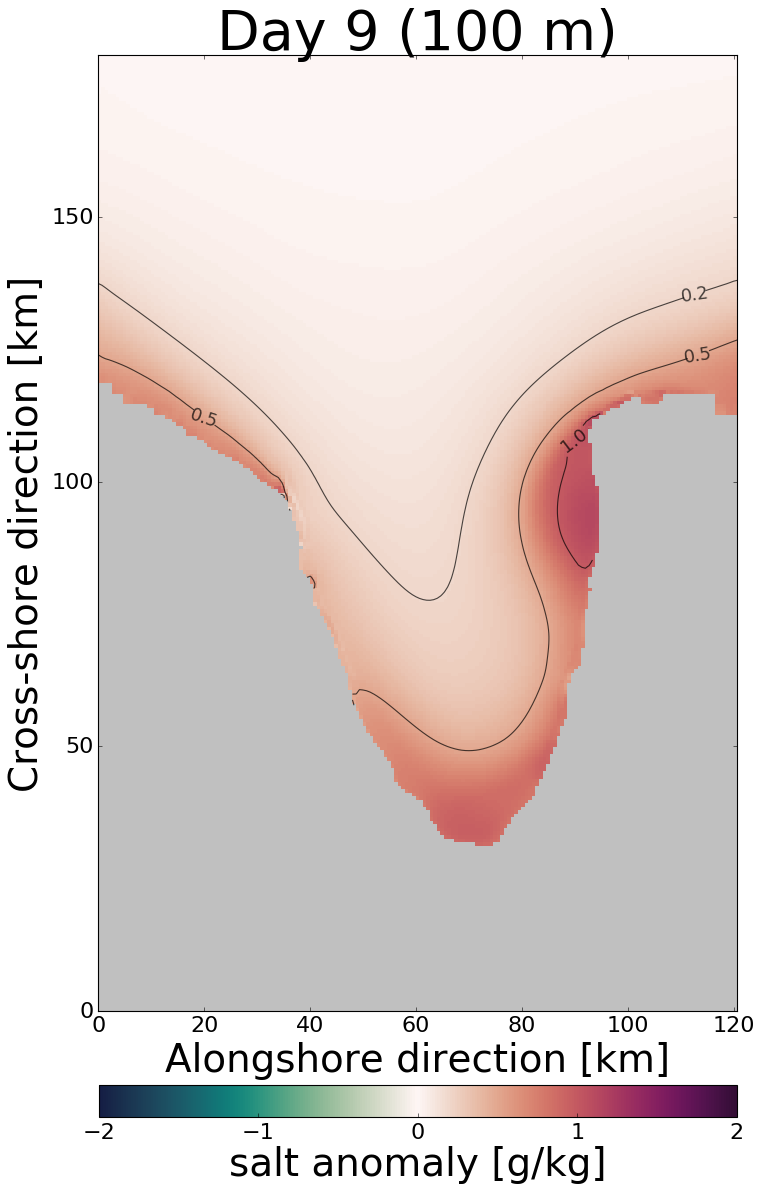

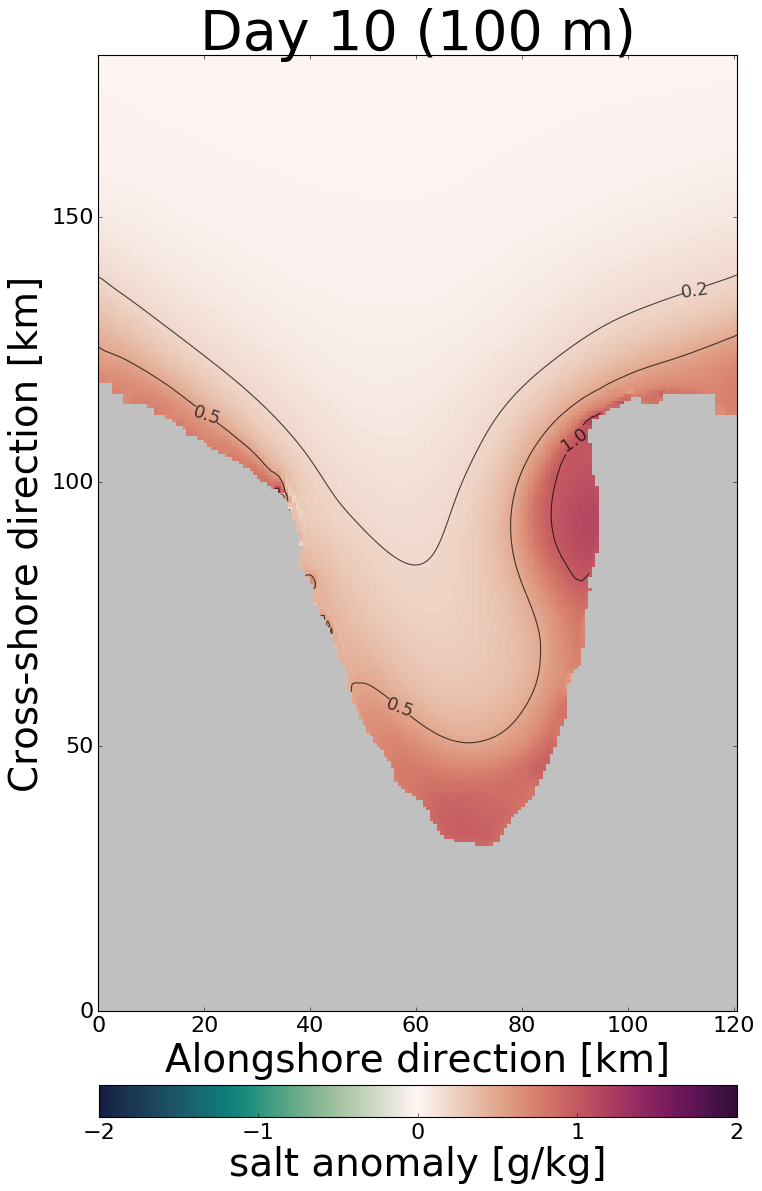

In [42]:
cbarf, cpad = 0.03, 0.07

for n in np.arange(10):
    fig = plot_saltanomaly_day(saltanomaly, deptht, dep_ind, n, cbarf, cpad, 'c', 'real')